In [1]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage

messages = [AIMessage(content=f"So you said you were researching ocean mammals?", name="Model")]
messages.append(HumanMessage(content=f"Yes, that's right.",name="Lance"))
messages.append(AIMessage(content=f"Great, what would you like to learn about.", name="Model"))
messages.append(HumanMessage(content=f"I want to learn about the best place to see Orcas in the US.", name="Lance"))

for m in messages:
    m.pretty_print()

================================== Ai Message ==================================
Name: Model

So you said you were researching ocean mammals?
================================ Human Message =================================
Name: Lance

Yes, that's right.
================================== Ai Message ==================================
Name: Model

Great, what would you like to learn about.
================================ Human Message =================================
Name: Lance

I want to learn about the best place to see Orcas in the US.


In [2]:
import os
from dotenv import load_dotenv
load_dotenv()

os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")

In [3]:
from langchain_groq import ChatGroq
llm=ChatGroq(model="gemma2-9b-it")
llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x0000028A97EE1D60>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x0000028A97EE2F90>, model_name='gemma2-9b-it', model_kwargs={}, groq_api_key=SecretStr('**********'))

In [4]:
def add(a:int,b:int)-> int:
    """Add a and b.

    Args:
        a: first int
        b: second int
    """
    return a+b

In [5]:
llm_with_tools = llm.bind_tools([add])

In [7]:
tool_call = llm_with_tools.invoke([HumanMessage(content="What is 1 plus 2?",name="Lance")])
tool_call

AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_1nyy', 'function': {'arguments': '{"a":1,"b":2}', 'name': 'add'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 87, 'prompt_tokens': 983, 'total_tokens': 1070, 'completion_time': 0.158181818, 'prompt_time': 0.034569728, 'queue_time': 0.245680871, 'total_time': 0.192751546}, 'model_name': 'gemma2-9b-it', 'system_fingerprint': 'fp_10c08bf97d', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-35c80433-e3c0-4f27-9559-4dabba384c60-0', tool_calls=[{'name': 'add', 'args': {'a': 1, 'b': 2}, 'id': 'call_1nyy', 'type': 'tool_call'}], usage_metadata={'input_tokens': 983, 'output_tokens': 87, 'total_tokens': 1070})

In [8]:
tool_call.tool_calls

[{'name': 'add',
  'args': {'a': 1, 'b': 2},
  'id': 'call_1nyy',
  'type': 'tool_call'}]

In [11]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages

class MessageState(TypedDict):
    messages:Annotated[list[AnyMessage],add_messages]

In [12]:
initial_message=[AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on generative ai.", name="Krish")
                   ]
# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

add_messages(initial_message,new_message)

[AIMessage(content='Hello! How can I assist you?', additional_kwargs={}, response_metadata={}, name='Model', id='0a97eeb1-eca8-4c5c-b748-e40cb9f12974'),
 HumanMessage(content="I'm looking for information on generative ai.", additional_kwargs={}, response_metadata={}, name='Krish', id='88341e23-1bcd-4298-8c02-36c677574f65'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', additional_kwargs={}, response_metadata={}, name='Model', id='20db4b4e-b313-4887-a3b0-9ca2fa918b2e')]

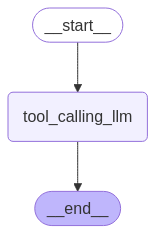

In [13]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
    
# Node
def tool_calling_llm(state: MessageState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessageState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_edge(START, "tool_calling_llm")
builder.add_edge("tool_calling_llm", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [14]:
messages=graph.invoke({"messages":HumanMessage(content="What is 2 minus 3")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

What is 2 minus 3
================================== Ai Message ==================================
Tool Calls:
  add (call_kjxg)
 Call ID: call_kjxg
  Args:
    a: 2
    b: -3


In [15]:

def multiply(a: int, b: int) -> int:
    """Multiply a and b.

    Args:
        a: first int
        b: second int
    """
    return a * b

In [16]:
llm_with_tools = llm.bind_tools([multiply,add])

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState


In [18]:
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

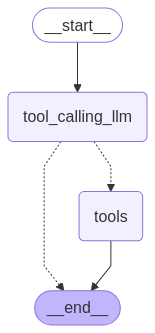

In [19]:
# Node
def tool_calling_llm(state: MessagesState):
    return {"messages": [llm_with_tools.invoke(state["messages"])]}

# Build graph
builder = StateGraph(MessagesState)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode([multiply,add]))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", END)
#builder.add_edge("tool2", END)
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [20]:
from langchain_core.messages import HumanMessage
messages = [HumanMessage(content="Add 3 and 4. Multiply the output by 2 and add 5.")]
messages = graph.invoke({"messages": messages})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Add 3 and 4. Multiply the output by 2 and add 5.
================================== Ai Message ==================================
Tool Calls:
  add (call_txh9)
 Call ID: call_txh9
  Args:
    a: 3
    b: 4
================================= Tool Message =================================
Name: add

7


In [ ]:
START -> CHATBOT -> END